# Acceptance map that "ruins" GENIE samples to mimic the detector

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/acceptance/'

In [3]:
versions['data date'] = '2018_05_11'
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [63]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'; print_line()

cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to data'
selected_events = reducedOnBeam['Pt & delta phi']
print len(selected_events),'selected pairs in data'

# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
Nevents = len(selected_events_tightFV)
print Nevents,'selected pairs in data in tight FV'

38163 pairs from On-Beam, 24323 in Fiducial Volume
--------------------------------------------------------------
applied cuts to data
350 selected pairs in data
182 selected pairs in data in tight FV


# afro GENIE samples with different $m_A$

In [5]:
sns.set(style='white');
mA_array = [0.6,0.7,0.8,0.9,0.99,1.1,1.2,1.4] # S.Dytman: GENIE assumes mA=0.99 GeV/c2 (Dec-30,2017)
mA_colors= ['red','blue','yellow','forestgreen','purple','orange','pink','teal']

In [187]:
genie_CC1p0pi = dict()
for mA in mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

28507 CC1p0π events in GENIE samples with mA=0.60
30599 CC1p0π events in GENIE samples with mA=0.70
32163 CC1p0π events in GENIE samples with mA=0.80
33824 CC1p0π events in GENIE samples with mA=0.90
34849 CC1p0π events in GENIE samples with mA=0.99
36196 CC1p0π events in GENIE samples with mA=1.10
37239 CC1p0π events in GENIE samples with mA=1.20
38810 CC1p0π events in GENIE samples with mA=1.40


# fit the $Q^2$ distributions in the GENIE samples 
in order to obtain a smooth parameterization of the probability distribution function for each sample

In [296]:
bins=linspace(0,1,25); mid=0.5*(bins[1:]+bins[:-1])
var,x_label='Q2',r'$Q^2$ (GeV/c)$^2$'

## Likelihood
$$ {\displaystyle {\hat {\ell }}(\theta \,;x)={\frac {1}{n}}\sum _{i=1}^{n}\ln f(x_{i}\mid \theta ),} $$

In [297]:
def find_Q2_bin( Q2, h, bins):
    for Q2_bin in range(len(bins)-1):
        if (Q2>bins[Q2_bin])&(Q2<bins[Q2_bin+1]):
            return Q2_bin
    return -1

In [303]:
debug=1
from superplot.statslib.kde import gaussian_kde
LL_df = pd.DataFrame(columns={'mA','LL'})
log_f_i=dict()
for mA in mA_array:
#     hGenie,hGenie_err = np.zeros(len(bins)-1),np.zeros(len(bins)-1)
#     for Q2_bin in range(len(bins)-1):
#         genie_in_bin = genie_CC1p0pi[mA][(genie_CC1p0pi[mA][var]>bins[Q2_bin])&(genie_CC1p0pi[mA][var]<bins[Q2_bin+1])]
#         weights_in_bin = genie_in_bin['MicroBooNEWeight_Pmu_theta_Pp_theta']
#         hGenie[Q2_bin] = np.sum(weights_in_bin)
#         hGenie_err[Q2_bin] = np.sqrt(np.sum(np.square(weights_in_bin)))
        
#     # normalize - to make it a PDF
#     hGenie_err = hGenie_err*(1./np.float(np.sum(hGenie)))
#     hGenie = hGenie*(1./np.float(np.sum(hGenie)))
    
    var_array = np.array(genie_CC1p0pi[mA][var])
    weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
    pdf = gaussian_kde(var_array,weights=weights)
#     x,y,yerr = mid,hGenie,hGenie_err
#     z = np.polyfit(x,y,deg=6)
#     pdf = np.poly1d(z)
#     x_poly = linspace(0.02,1,100); dx=(x_poly[1]-x_poly[0]);
#     integral = np.sum( [pdf(x)*dx for x in x_poly] )

    # now compute the likelihood of the data
#     LL = 0
#     log_f_i[mA] = []
    f = pdf(selected_events_tightFV['reco_Q2'])    
    LL = np.sum(np.log(f))/len(f)
#     print 'f:',f
#     print 'LL:',LL
#     for i,event in selected_events_tightFV.iterrows():    
#         Q2_i = np.min( [0.98 , np.max([0.02 , event['reco_Q2']])])
#         f_i = np.max([1e-5 , pdf(Q2_i)]) # cutoff to prevent negative Q2 values
#         Q2_bin = find_Q2_bin( Q2_i, hGenie, bins)
# #         print 'Q2_bin:',Q2_bin
#         if Q2_bin==-1: f_i=1e-5
#         else:
# #         f_i = np.max([1e-5 , pdf(Q2_i)/integral]) # cutoff to prevent negative Q2 values

# #             f_i = np.max([1e-5 , hGenie[Q2_bin]]) # cutoff to prevent negative Q2 values
#         LL += np.log(f_i)
#         log_f_i[mA].append(np.log(f_i))
#         if np.log(f_i)>max_log_f_i:
#         if mA==1.4:
#         max_log_f_i = np.log(f_i)       
#         print 'mA=',mA,',Q2_i:%.2f'%Q2_i,',f_i:%.2f'%f_i,',np.log(f_i):%.1f'%np.log(f_i)
    LL_df = LL_df.append(pd.DataFrame({'mA':mA,'LL':LL},index=[mA]))
    
    if debug:
#         print 'poly:',poly
#         print 'hGenie:',hGenie
#         print 'hGenie_err:',hGenie_err        
        print 'np.min(f):',np.min(f)
        print 'np.min(np.log(f)):',np.min(np.log(f)),'np.max(np.log(f)):',np.max(np.log(f))

        print 'LL:',LL
    print 'done mA=%.2f'%mA
LL_df

np.min(f): 0.0321506165714
np.min(np.log(f)): -3.43732365052 np.max(np.log(f)): 0.9841813737
LL: 0.433048868988
done mA=0.60
np.min(f): 0.0303178443007
np.min(np.log(f)): -3.496018819 np.max(np.log(f)): 0.976730682497
LL: 0.432038516515
done mA=0.70
np.min(f): 0.0298598845173
np.min(np.log(f)): -3.51123935435 np.max(np.log(f)): 0.967917901604
LL: 0.430267274169
done mA=0.80
np.min(f): 0.0348751494534
np.min(np.log(f)): -3.35598075345 np.max(np.log(f)): 0.94452676837
LL: 0.430539451929
done mA=0.90
np.min(f): 0.0436695759292
np.min(np.log(f)): -3.13110362234 np.max(np.log(f)): 0.920457483316
LL: 0.427480474838
done mA=0.99
np.min(f): 0.0458030071532
np.min(np.log(f)): -3.08340553165 np.max(np.log(f)): 0.889444990787
LL: 0.422313227769
done mA=1.10
np.min(f): 0.0458952326662
np.min(np.log(f)): -3.08139403079 np.max(np.log(f)): 0.871082856353
LL: 0.416479386615
done mA=1.20
np.min(f): 0.0547378302767
np.min(np.log(f)): -2.90520021304 np.max(np.log(f)): 0.841177332448
LL: 0.407240325678
do

,LL,mA
0.60,0.433049,0.60
0.70,0.432039,0.70
0.80,0.430267,0.80
0.90,0.430539,0.90
0.99,0.427480,0.99
1.10,0.422313,1.10
1.20,0.416479,1.20
1.40,0.407240,1.40


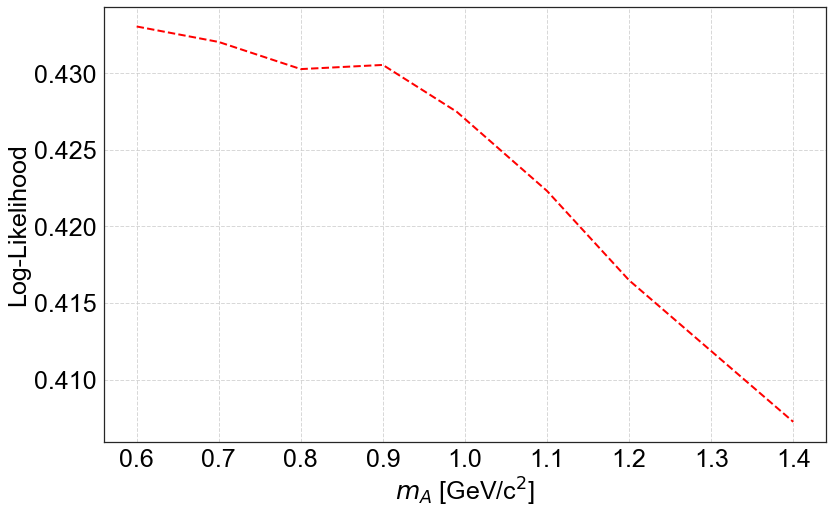

In [304]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
plt.plot( LL_df['mA'] , LL_df['LL'] , '--',color='red',linewidth=2)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','Log-Likelihood',do_add_grid=True)

np.sum(h): 160.0
np.sum(h): 153.0
np.sum(h): 164.0
np.sum(h): 173.0
np.sum(h): 177.0
np.sum(h): 181.0
np.sum(h): 182.0
np.sum(h): 182.0


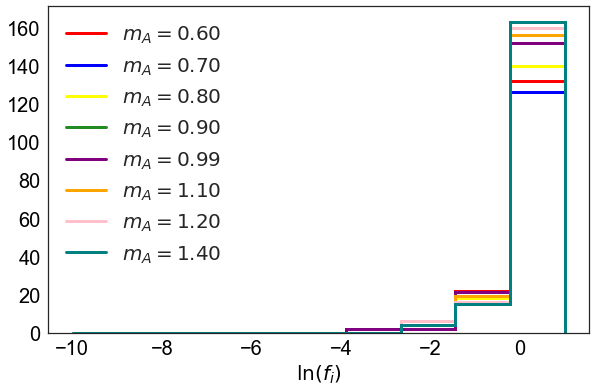

In [262]:
fig,ax=plt.subplots(figsize=(9.708,6))
for mA,c in zip(mA_array,mA_colors):
    h,_,_=plt.hist(log_f_i[mA],bins=linspace(-10,1,10),histtype='step',linewidth=3,color=c)
    print 'np.sum(h):',np.sum(h)
    plt.plot([0,0],[0,0],linewidth=3,color=c,label=r'$m_A=%.2f$'%mA)
set_axes(ax,r'$\ln (f_i)$','',do_add_legend=True,legend_loc='upper left',fontsize=20)    

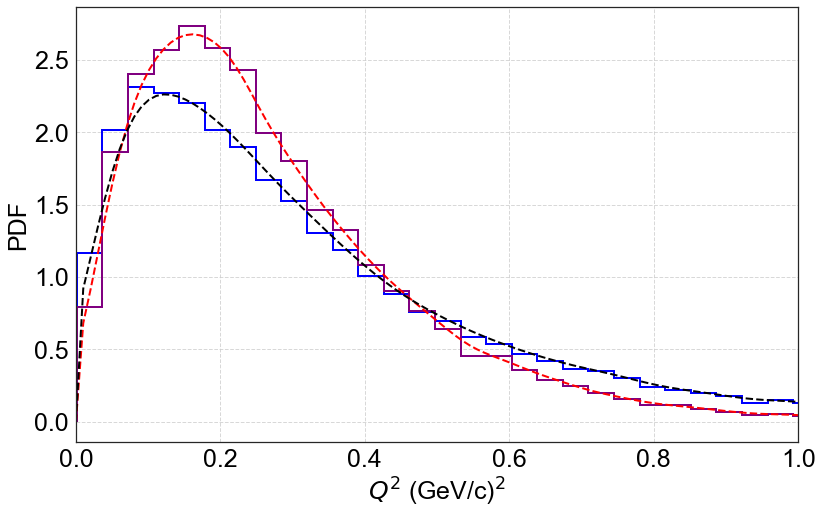

In [312]:
fig=plt.figure(figsize=(12.944,8)); ax=fig.add_subplot(1,1,1)
for mA,color in zip(mA_array[0:1],mA_colors):
    var_array = np.array(genie_CC1p0pi[mA][var])
    weights = np.array(genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'])
    pdf = gaussian_kde(var_array,weights=weights)
    x_poly = linspace(0,1,100); dx=(x_poly[1]-x_poly[0]);
    ax.plot(x_poly, pdf(x_poly), '--',color=color,linewidth=2)

    pdf_nw = gaussian_kde(var_array,weights=None)
    ax.plot(x_poly, pdf_nw(x_poly), '--',color='black',linewidth=2)
    ax.hist(genie_CC1p0pi[mA]['Q2'],bins=100,histtype='step',color='blue',linewidth=2,normed=1)
    ax.hist(genie_CC1p0pi[mA]['Q2'],weights=genie_CC1p0pi[mA]['MicroBooNEWeight_Pmu_theta_Pp_theta'],bins=100,histtype='step',color='purple',linewidth=2,normed=1)


set_axes(ax,x_label,'PDF',do_add_grid=True,xlim=(0,1))